# HW 6
ENGN2912V

Seokkee Min

# P3 - Regularization

## L1 and L2 Regularization

In [1]:
import jax
from jax import numpy as jnp
from jax import jit, grad, vmap, random, value_and_grad
import numpy as np
import matplotlib.pyplot as plt
import optax

In [2]:
def x_uni(n, lb, ub):
    x = jnp.linspace(lb, ub, n, dtype=np.float32)
    return x

def f3(x):
    x = np.array(x)
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < 0:
            j = 0
            y[i] = 5
            for j in range(5):
                y[i] += np.sin((j+1)*x[i])
        if x[i] >= 0:
            y[i] = np.cos(10*x[i])
    noise = np.random.normal(0, 0.1, len(y))
    y += noise
    y = jnp.array(y)
    return y

In [3]:
def l1_loss(x, alpha):
    return alpha * jnp.abs(x).mean()

def l2_loss(x, alpha):
    return alpha * (x ** 2).mean()


In [4]:
def get_random_layer_params(m, n, random_key, scale=0.01):
    w_key, b_key = random.split(random_key)
    weights = 1/(jnp.sqrt(m+n)) * random.normal(w_key, (n, m))
    biases = jnp.zeros((n,)) 
    return weights, biases

def get_init_network_params(sizes, ran_key):
    keys = random.split(ran_key, len(sizes))
    return [get_random_layer_params(m, n, k) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def feedforward_prediction(params, x):     
    for w, b in params[:-1]:
        outputs = jnp.dot(w, x) + b  
        x = jax.nn.relu(outputs)  
    w_final, b_final = params[-1] 
    final_outputs = jnp.dot(w_final, x) + b_final 
    return final_outputs  

batched_prediction = vmap(feedforward_prediction, in_axes=(None, 0))

@jit
def mse_loss_l1(params, x, y, alpha):
    preds = batched_prediction(params, x)
    diff = preds - y
    loss = jnp.sum(diff*diff)/preds.shape[0]
    loss += sum(
        l1_loss(w, alpha)
        for w in jax.tree_util.tree_leaves(params)
    )
    return loss 

@jit
def mse_loss_l2(params, x, y, alpha):
    preds = batched_prediction(params, x)
    diff = preds - y
    loss = jnp.sum(diff*diff)/preds.shape[0]
    loss += sum(
        l2_loss(w, alpha)
        for w in jax.tree_util.tree_leaves(params)
    )
    return loss 

@jit
def predict(params, x_pred):
    y_pred = batched_prediction(params, x_pred)
    return y_pred
# @jit
# def update_l1(params, x, y, learning_rate, alpha):
#     l, grads = value_and_grad(mse_loss_l1)(params, x, y, alpha)
#     return [(w - learning_rate * dw, b - learning_rate * db) 
#             for (w, b), (dw, db) in zip(params, grads)], l

# @jit
# def update_l2(params, x, y, learning_rate, alpha):
#     l, grads = value_and_grad(mse_loss_l2)(params, x, y, alpha)
#     return [(w - learning_rate * dw, b - learning_rate * db) 
#             for (w, b), (dw, db) in zip(params, grads)], l


In [5]:
def L2_Error(y, y_pred):
    f2norm = jnp.linalg.norm(y, ord=2)
    n_f_norm = jnp.linalg.norm(y_pred - y, ord=2)
    error = n_f_norm/f2norm
    return error

In [6]:
SEED = 1234
key = random.PRNGKey(SEED)
lr = 1e-02

num_features = 1
# num_traget = 1
num_batches = 80
layers = [1] + [32]*8 + [1]
optimizer = optax.adam(lr)
ran_key, func_key = random.split(key)

x_train = x_uni(num_batches, -np.pi, np.pi)
x_train = x_train.reshape((num_batches, num_features))
y_train = f3(x_train)
y_train = y_train.reshape((num_batches, num_features))

train_batch = 1000

x_pred = x_uni(train_batch, -np.pi, np.pi)
x_pred = x_pred.reshape((train_batch, num_features))
y_test = f3(x_pred)
y_test = y_test.reshape((train_batch, num_features))

In [7]:
alpha = 1e-4                # user change value
Niter = 10000             # user change value

i=0, train_loss=Array(9.186535, dtype=float32), test_loss=Array(0.98358244, dtype=float32)

i=2000, train_loss=Array(0.0157189, dtype=float32), test_loss=Array(0.06525914, dtype=float32)

i=4000, train_loss=Array(0.00299938, dtype=float32), test_loss=Array(0.06579093, dtype=float32)

i=6000, train_loss=Array(0.00372265, dtype=float32), test_loss=Array(0.06578167, dtype=float32)

i=8000, train_loss=Array(0.0009181, dtype=float32), test_loss=Array(0.06294043, dtype=float32)

i=10000, train_loss=Array(0.00061315, dtype=float32), test_loss=Array(0.05834273, dtype=float32)



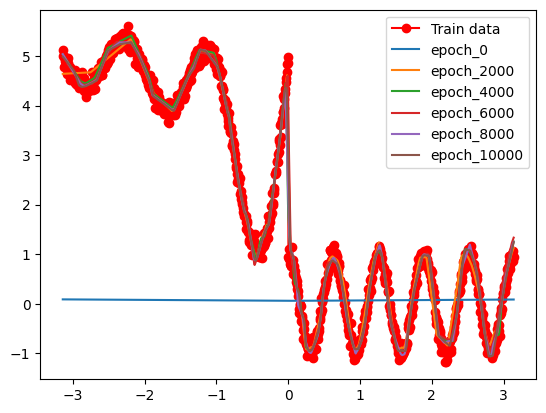

In [16]:
params = get_init_network_params(layers, ran_key)
opt_state = optimizer.init(params)

L_train = np.zeros(Niter+1)
# L_pred = np.zeros(Niter+1)

plt.plot(x_pred, y_test, "-ro", label="Train data")
for i in range(0, Niter+1):
    train_loss, grads = value_and_grad(mse_loss_l1)(params, x_train, y_train, alpha)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    L_train[i] = train_loss
    
    if i % 2000 == 0:
        y_pred = predict(params, x_pred)
        y_pred = y_pred.reshape((train_batch, num_features))
        test_loss = L2_Error(y_test, y_pred)
        print(f"{i=}, {train_loss=}, {test_loss=}\n")
        plt.plot(x_pred, y_pred, label = "epoch_" + str(i))
        
plt.legend()

I tried first running a narrow and shallow network, with the penalty weight of the L1 regulator set to 1e-3 (alpha), and noticed that my error never went below approx 10%. Then I tried making the network much deeper to 10 layers (and increased width to 32 in order to prevent collapse), but was never able to go below 6% error). At 15 layers, the network partially collapsed. Then I moved to a network of width 32, adjusting the network depth until settling on 8 hidden layers, where I was getting good performance, and adjusted alpha.

At alpha = 1e-1, the testing error (L2 relative error) remained high (approx 70%). By decreasing alpha by an order of magnitude until 1e-6 gave me the same results as before (approx 6% testing error). 

Having the penalty term alpha around 1e-4 gave a better result of a test error below 6% after 10000 iterations (with Adam optimizer). Even after 30000 epochs, the testing error remains stable around 6%, and training error goes to approx 0.03%. Although the training error decreases faster than without the regularizer, the decrease plateaus higher than without the regularizer due to the penalty term. This most likely indicates that there will be less potential over-fitting, even though I was not able to demonstrate the testing error increasing again, within the above number of epochs.

Bora said around 6% testing error was OK.

i=0, train_loss=Array(9.186456, dtype=float32), test_loss=Array(0.9831576, dtype=float32)

i=2000, train_loss=Array(0.13674305, dtype=float32), test_loss=Array(0.13248803, dtype=float32)

i=4000, train_loss=Array(0.07663096, dtype=float32), test_loss=Array(0.10355617, dtype=float32)

i=6000, train_loss=Array(0.07523462, dtype=float32), test_loss=Array(0.10971249, dtype=float32)

i=8000, train_loss=Array(0.0010392, dtype=float32), test_loss=Array(0.06538186, dtype=float32)

i=10000, train_loss=Array(0.00090306, dtype=float32), test_loss=Array(0.06505392, dtype=float32)



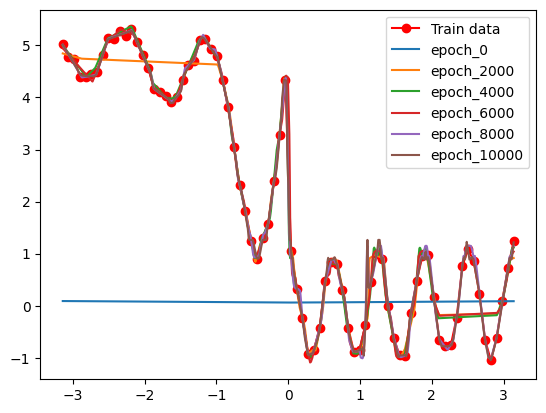

In [17]:
params2 = get_init_network_params(layers, ran_key)
opt_state2 = optimizer.init(params)
alpha = 1e-4

Niter = 10000
L2_train = np.zeros(Niter+1)

plt.plot(x_train, y_train, "-ro", label="Train data")
for i in range(0, Niter+1):
    train_loss, grads2 = value_and_grad(mse_loss_l2)(params2, x_train, y_train, alpha)
    updates2, opt_state2 = optimizer.update(grads2, opt_state2)
    params2 = optax.apply_updates(params2, updates2)
    
    L2_train[i] = train_loss
    
    if i % 2000 == 0:
        y_pred = predict(params2, x_pred)
        y_pred = y_pred.reshape((train_batch, num_features))
        test_loss = L2_Error(y_test, y_pred)
        print(f"{i=}, {train_loss=}, {test_loss=}\n")
        plt.plot(x_pred, y_pred, label = "epoch_" + str(i))
plt.legend()

#     params2, train_loss = update_l2(params2, x_train, y_train, lr, alpha)
#     if i % 25000 == 0:
#         y_pred = batched_prediction(params2, x_pred)
#         y_pred = y_pred.reshape((train_batch, num_features))
#         test_loss = L2_Error(y_test, y_pred)
#         print(f"{i=}, {train_loss=}, {test_loss=}\n")
#         plt.plot(x_pred, y_pred, label = "epoch_" + str(i))
# plt.legend()

Similar results for the L2 regularizer compared to L1, but a little slower in the testing error decrease, which settled around 6.5%.

Performance of L1 vs L2 may be dependent on activation function, and perhaps L1 had better compatibility with ReLU (used here)

## Dropout Regularizer

In [8]:
from flax import linen as nn
from flax.training import train_state, checkpoints
# from functools import partial

In [9]:
rng = random.PRNGKey(1234)
main_key, params_key, dropout_key = jax.random.split(rng,3)

In [64]:
class DropoutNN(nn.Module):
    num_hidden: int = 32
    num_outputs: int = 1
    drop_out_r: float = 0.0001
    
    @nn.compact
    def __call__(self, x, training: bool):
                
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        # x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        # x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        # x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        # x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        #x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_hidden)(x)
        x = nn.relu(x)
        # x = nn.Dropout(rate = self.drop_out_r, deterministic = not training)(x)
        
        x = nn.Dense(self.num_outputs)(x)        
        return x

In [65]:
my_model = DropoutNN()
x_drop = jnp.empty(np.shape(x_train))
variables = my_model.init(params_key, x_drop, training = False)
params = variables['params']

In [66]:
y = my_model.apply({'params': params}, x_drop, training=True, rngs={'dropout': dropout_key})

In [67]:
class TrainState(train_state.TrainState):
    key: jax.random.KeyArray
    
state = TrainState.create(
    apply_fn=my_model.apply,
    params=params,
    key=dropout_key,
    tx=optax.adam(1e-4)
)

In [68]:
def loss_fn(params, x_train, y_train, dropout_train_key):
    preds = my_model.apply({'params':params},
                              x_train,
                              training = True,
                              rngs = {'dropout': dropout_key}
                             )
    preds = preds.reshape(np.shape(y_train))
    f2norm = jnp.linalg.norm(y_train, ord=2)
    n_f_norm = jnp.linalg.norm(preds - y_train, ord=2)
    loss = n_f_norm/f2norm
    return loss, preds        

@jit
def train_step(state, x_train, y_train, dropout_key):
    dropout_train_key = jax.random.fold_in(key=dropout_key, data=state.step)
    grad_fn = value_and_grad(loss_fn, has_aux=True)
    (loss, preds), grads = grad_fn(state.params, x_train, y_train, dropout_train_key)
    state = state.apply_gradients(grads=grads)
    return state, loss, preds

In [69]:
#@jit
def pred_step(state, x, dropout_key):
    pred = my_model.apply({'params': state.params}, x, training=False, rngs = {'dropout': dropout_key})
    return pred

In [70]:
def test_error(state, x_pred, y_test, dropout_key):
    preds = pred_step(state, x_pred, dropout_key)
    
    f2norm = jnp.linalg.norm(y_test, ord=2)
    n_f_norm = jnp.linalg.norm(preds - y_test, ord=2)
    
    loss = n_f_norm/f2norm
    return loss, preds  

In [71]:
Diter = 20000
L_drop = np.zeros(Diter+1)

epoch: 0, training loss: 1.0006, test loss: 0.9996
epoch: 2000, training loss: 0.1689, test loss: 0.1754
epoch: 4000, training loss: 0.1511, test loss: 0.1602
epoch: 6000, training loss: 0.1455, test loss: 0.1561
epoch: 8000, training loss: 0.1410, test loss: 0.1513
epoch: 10000, training loss: 0.1196, test loss: 0.1315
epoch: 12000, training loss: 0.0649, test loss: 0.0898
epoch: 14000, training loss: 0.0246, test loss: 0.0702
epoch: 16000, training loss: 0.0224, test loss: 0.0692
epoch: 18000, training loss: 0.0217, test loss: 0.0686
epoch: 20000, training loss: 0.0220, test loss: 0.0687


Text(0.5, 1.0, 'Test')

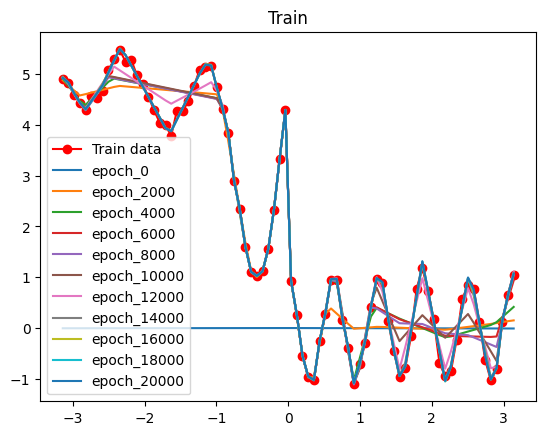

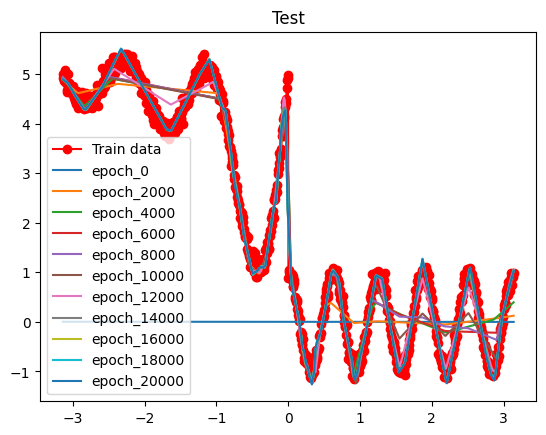

In [72]:
L_drop = np.zeros(Diter+1)
# test_loss_drop = np.zeros(int(Niter/10000+1))
# y_predict = np.zeros(int(Niter/10000+1))

fig1 = plt.figure(1)
plt.plot(x_train, y_train, "-ro", label="Train data")

fig2 = plt.figure(2)
plt.plot(x_pred, y_test, "-ro", label="Train data")

for i in range(Diter+1):
    state, loss, train_pred = train_step(state, x_train, y_train, dropout_key)
    L_drop[i] = loss
    
    if i % 2000 == 0 :
        test_loss, preds = test_error(state, x_pred, y_test, dropout_key)
        # test_loss_drop[k] = test_loss
        # y_predict[k] = preds
        # k += 1
        
        print("epoch: %d, training loss: %.4f, test loss: %.4f" % (i, loss, test_loss))
        plt.figure(1)
        plt.plot(x_train, train_pred, label = "epoch_" + str(i))
        plt.figure(2)
        plt.plot(x_pred, preds, label = "epoch_" + str(i))
plt.figure(1)        
plt.legend()
plt.title("Train")

plt.figure(2)
plt.legend()

plt.title("Test")

#### When there is a dropout implemented in every layer, 
Dropout Rate:

0.0: training error doesn't reach 1e-3 after 100000 epochs (error settles around 0.0141) 

0.1: training error reaches 1e-3 after 2400 epochs. 

0.4: training error reaches 1e-3 after 1500 epochs.

0.5: training error reaches 1e-3 after 1400 epochs. 

0.75: training error doesn't reach 1e-3 after 100000 epochs (error settles around 0.1508)


Much faster than L1 and L2 regularizers (took around 8000 epochs), when the training rate is set appropriately. When dropout rate is too low, or too high, then error remains high. This is either because there is no benefit (when dropout rate is too low), or training for individual neurons doesn't occur very frequently (due to high dropout rate)

Testing error doesn't go down however, when dropout is implimented in every layer, probably because there is too little feedforward. As such, I decreased the number of dropout layers in the subsequent iterations.


#### When there is only dropout in last non-linear layer,
dropout rate:

0.4: training error goes down as before, test loss goes down more than before, but plateaus around 0.46 after 20000 epochs

0.1: test loss goes down faster than 0.4 dropout rate, and test error plateaus lower around 0.3 

0.001: training loss plateaus higher than before, but test error plateaus lower around 0.13

0.0001: training loss plateaus around 0.14, test error plateaus higher around 0.15




#### Dropout rate = 0.001

Dropout layers (out of 8 non-linear layers):

4, 6, 8(last): test loss plateau around 0.11 after 12000 epochs

4, 6: test loss plateau around 0.07 after 16000 epochs

2, 4, 6, 8: test loss around 0.11 after 20000 epochs




#### Dropout Layers 4 and 6 (8 layers):

0.001: test error plateaus lower around 0.13

0.0005: test error around 0.06 after 20000 epochs

0.0001: test error around o.07 after 20000 epochs